# Networks Exercise

In [17]:
# Imports 
import sys
from py2neo import authenticate, Graph, Relationship
#from py2neo.cypher import CypherWriter
#import MySQLdb
import pandas
import pymysql
import numpy as np
import operator 
import pprint



## Connect to the Neo4j Database
Run the cell below to set up a connection to the Neo4j database using py2neo

In [2]:
# set up authentication parameters
authenticate("localhost:7474", "neo4j", "upintheA1R!!")

# Create a variable for our graph and print our connection infomation
graph_db = Graph()
print graph_db


<Graph uri=u'http://localhost:7474/db/data/'>


#### The cell below is intended for you to test Cypher Queries

# Introduction to Neo4j and Cypher
## What is a Graph Database?

### Quick Review of Neo4j and Cypher 

When you think of data, you probably imagine an excel table where each row is an individual observation or data point. 
For example, 

|name | age | employee_id|
|-----|-----|------------|
|Joe  |  34 |   12345    |
|Ann  |  54 |   12346    |
    
In a graph database, that row is more like a ball. 


##### (node: Employee {name:Joe, age: 34, employee_id: 12345})

This ball is called a "node" in Neo4j. In fact, the little parentheses around Joe's information are designed to help the user think of Joe's information as a little ball. 

All the information about Joe is still there, but it's just not in a flat table format. Instead of storing each peice of Joe's information in a variable column, Joe's information is stored as **properties**, ie name, age, employee_id.
Joe's node also has a **label**, *Employee*, to identify this node as belonging to an employee.


Neo4j uses the Cypher Query Language to get information out of the Database. 

##### Components of a simple Cypher Query:
+ MATCH      
     - Essentially the same thing as SELECT in SQL 
+ (n)        
    - Any node (the n is just a variable, could be any letter) 
+ RETURN     
    - Needed in every query 
+ LIMIT      
    - Same as in SQL 

The following query will return 20 nodes from the database:  
##### graph_db.cypher.execute("MATCH (n) RETURN n LIMIT 20")

If I wanted to query just Award nodes, I would run this query;  
##### graph_db.cypher.execute("MATCH (n:Award) RETURN n LIMIT 20")


## Part A (X points) - Cypher Query language

### Write a query that matches 10 nodes of type Employee and returns the employeeid. Limit to 10 nodes.

In [3]:
graph_db.data("MATCH (n:Employee) RETURN n.employeeid LIMIT 10")

[{u'n.employeeid': u'90014540'},
 {u'n.employeeid': u'90026679'},
 {u'n.employeeid': u'90017693'},
 {u'n.employeeid': u'90028696'},
 {u'n.employeeid': u'90013819'},
 {u'n.employeeid': u'90001118'},
 {u'n.employeeid': u'90001300'},
 {u'n.employeeid': u'90023086'},
 {u'n.employeeid': u'90017074'},
 {u'n.employeeid': u'90025003'}]

In [ ]:
"""
Your query should return a list containing dictonaries.

Returned Object from py2neo

[{u'n.employeeid': u'90014540'},
 {u'n.employeeid': u'90026679'},
 {u'n.employeeid': u'90017693'},
 {u'n.employeeid': u'90028696'},
 {u'n.employeeid': u'90013819'},
 {u'n.employeeid': u'90001118'},
 {u'n.employeeid': u'90001300'},
 {u'n.employeeid': u'90023086'},
 {u'n.employeeid': u'90017074'},
 {u'n.employeeid': u'90025003'}]
"""
print "________"

What makes graph databases like Neo4j special is the ability to create relationships between nodes:

For instance, the database has two types of relationships; WORKED_ON  and WORKED_WITH
 + Employees have a *WORKED_ON* relationship with nodes which represent awards on which the person has worked.   
 + Employees have a *WORKED_WITH* relationship other persons that have worked on the same award.   

To view what this looks like, this query will return 5 instances of the pattern where an employee worked_on an award, and return the relationship. 

#### graph_db.cypher.execute("MATCH (e)-[r:WORKED_ON]->(a) RETURN  r LIMIT 5;")

If you look at this query you kinda see a pattern of (node1) -[relationship]-> (node2). You can imagine that this is one ball with an arrow pointing to another ball. Each ball is a node of data and the arrow is a relationship.  What this query is asking the the database to do is go through all the nodes and relationships and find the pattern where one node has a realtionship pointing to another node and that realtionship has the label "WORKED_ON".  


### Write a query that matches nodes of type Employee that have a WORKED_WITH relationship with another node of type Employee. return the employeeid of both employee nodes. Limit the response to 5.  

In [4]:
graph_db.data("MATCH (a)-[r:WORKED_WITH]->(b) RETURN a.employeeid, b.employeeid LIMIT 5;") 

[{u'a.employeeid': u'90000919', u'b.employeeid': u'90028696'},
 {u'a.employeeid': u'90024693', u'b.employeeid': u'90013819'},
 {u'a.employeeid': u'90001652', u'b.employeeid': u'90001118'},
 {u'a.employeeid': u'90025754', u'b.employeeid': u'90001300'},
 {u'a.employeeid': u'90022371', u'b.employeeid': u'90023086'}]

In [5]:
"""
Your query should return a list containing dictonaries.

[{u'a.employeeid': u'90000919', u'b.employeeid': u'90028696'},
 {u'a.employeeid': u'90024693', u'b.employeeid': u'90013819'},
 {u'a.employeeid': u'90001652', u'b.employeeid': u'90001118'},
 {u'a.employeeid': u'90025754', u'b.employeeid': u'90001300'},
 {u'a.employeeid': u'90004472', u'b.employeeid': u'90023086'}]

"""
print "_______"



_______


## Neo4j and Networkx 

This would all be so much cooler if you could see the data, right?

But first, we have to convert our neo4j database into a networks objects 
Pulling data from a cypher query into networkx objects with example

In [13]:
#Imports that should really be at the top of the notebook 
import networkx
# Allows plots to be showed inline 
#import matplotlib as plt
%matplotlib inline


# Get ALL the Nodes and relationsips 
# The below query translates to,
# find all nodes that have a retlationship with another node
# (this is any node in our graph)
# Return all the data for the nodes and relationships that are found 
all_data = graph_db.data("MATCH (n1) -[r]-> (n2) RETURN n1, r, n2;") 

#Convert all_data to a dataframe object
all_data_df = pandas.DataFrame(all_data)

# Adding a 'weight' to see connections better
all_data_df['weight'] = .01

# Create a Networkds Graph of all the Data 
all_data_g = networkx.from_pandas_dataframe(all_data_df, 'n1', 'n2', ['weight'])



### Graph all the Data! 
Run the cell below to create a networkx graph of all the data

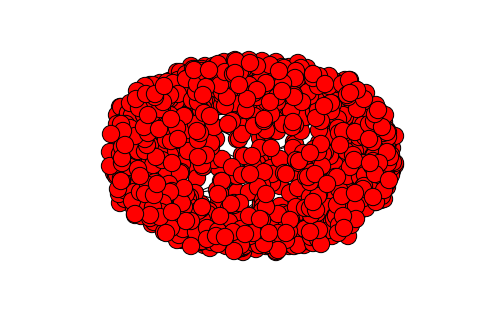

In [14]:
# Create a Color Map
# color_map =[]
# for node in all_data_g.nodes(data =True):
#     this_labels = node[1]['labels']
#     if 'Employee' in this_labels:
#         color_map.append('green')
#     elif 'Student' in this_labels:
#         color_map.append('yellow')
#     elif 'Award' in this_labels:
#         color_map.append('red')
        
        
# networkx.draw(all_data_g, node_color=color_map)
networkx.draw(all_data_g)

**Admittently, this is not the most informative graph.  There are too many nodes and connections to be able to see any patterners or insigths in the dataset. At best, you might be able to get a rough idea of the relative number of Employees, to awards to students **

### We just created a plot of all the Employees, Students, and Awards in the Graph.  Now lets practice plotting subgraphs. 
 

### Write a function that accepts an specific Award Number, finds all the Employees/Students who worked on that award, and return the data as a networkx graph. Also, have your function plot the graph. 



**Hint: The folowing line returns the employees and student who worked on the award aw1006**
MATCH (n) -[r:WORKED_ON] -> (a:Award {award_num:'aw1006'}) RETURN n,r

**Hint: you can pass parameters to a ipython magic call by placing the parameter in curly brakets, the cell below shows an example**


In [15]:
# This is the employee id of an employee I would like to search for. It is saved into a parameter, employee_id_parameter 
employee_id_parameter = '90022882'

# This line searches for an employye where the employee id is provided by the parameter, employee_id_parameter 
# This query translate to,
# Find the Node of type Employee where the employee id is equal to the value in the
# variable employee_id_parameter. Return that nodes data. 
graph_db.data("MATCH (e:Employee {employeeid:" + "'" + employee_id_parameter + "'" +"}) RETURN e;") 

[{u'e': (a6dcbd8:Employee {employeeid:"90022882",position:"FACULTY"})}]

  a.award_num n.employeeid
0      aw1501     90047948
1      aw1501        29193
2      aw1501     90028906


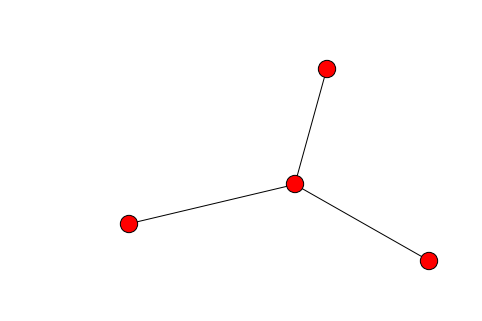

In [18]:
def employee_peers(award_num):
    """
    Creates a networkx plot of employees and students that have worked on an award.
    
    Parameters
    ----------
    award_num - The award_num of a specifc award, ie aw1006
    
    Returns 
    --------
    A Networkx graph object of an award and the persons who worked on that award 
    
    """
    # Collect Employees that worked with that Employee 
 
    award = award_num
    # This Cypher Query translates to,
    # Fins the nodes that have a WORKED_ON relationship with an node of type Award that has the award_num of the value of the 
    # award variable. Return the employeeid and award number of the found nodes 
    query = graph_db.data("MATCH (n) -[r:WORKED_ON]-> (a:Award {award_num:" + "'" + award + "'" + "}) RETURN n.employeeid, a.award_num;") 
    
    # Convert to DataFrame
    node_data = pandas.DataFrame(query)
    pprint.pprint(node_data)

    # Create the Networkx Graph 
    G = networkx.from_pandas_dataframe(node_data, 'n.employeeid', 'a.award_num')
    
#     color_map =[]
#     for node in G.nodes(data =True):
#         this_labels = node[1]['labels']
#         if 'Employee' in this_labels:
#             color_map.append('green')
#         elif 'Student' in this_labels:
#             color_map.append('yellow')
#         elif 'Award' in this_labels:
#             color_map.append('red')

#     networkx.draw(G, node_color=color_map)
    networkx.draw(G)
    
    #Return the Graph Object 
    return G 
        
# Testing the function with the award aw1501
employee_peers("aw1501")

## Anaylsing Networks 
The networkx module also has built in tools to analyse graphs. The following measurements are used to acess how the nodes are related to each other in the graph database.

### Network Measurments 
This is the vacab for studing a network 

 **Degree Centrality ** - counts the number of edges that a node has 
     - Nodes with a high degree of connections usally play an important role in a network 
 **Betweenness ** - indicator of a nodes centality in a network. 
     - Equal to the number of shortes paths from all vertices to all others that pass through that node 
 **Diameter** - The longest shrortest path over all pairs of nodes 
     - Often we want to find the shortest distance between two nodes, the diameter is the longest of theses paths 
     - Nodes that occur on many shortest paths between other nodes in the graph have a high betweenness centrality score 
 **Cliques ** - A clique is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent.

The functions below are written for your conviencenceby http://www.slideshare.net/arnicas/a-quick-and-dirty-intro-to-networkx-and-d3

     
   
 

In [19]:
def calculate_degree_centrality(graph):
    ''' 
    Calculate degree centrality of a node, sets value on node as attribute; returns graph, and dict of the degree centrality values.
	Also has code to print the top 10 nodes by degree centrality to console
    
    Parametes
    ----------
    graph - A Networkx object Graph 
	'''
    g = graph
    dc = networkx.degree_centrality(g)
    networkx.set_node_attributes(g, 'degress_centrality', dc)
    degcent_sorted = sorted(dc.items(), key = operator.itemgetter(1), reverse = True)
    for key, vlaue in degcent_sorted[0:10]:
        print "Highest degree Centrality:", key, vlaue
    return graph, dc 

In [26]:
def calculate_betweenness(graph):
    ''' 
    Calculate betweenness centrality of a node, sets value on node as attribute; returns graph, and dict of the betweenness centrality values

    Parametes
    ----------
    graph - A Networkx object Graph 
    '''
    g = graph
    bc=networkx.betweenness_centrality(g)
    networkx.set_node_attributes(g,'betweenness',bc)
    degcent_sorted = sorted(bc.items(), key = operator.itemgetter(1), reverse = True)
    for key, vlaue in degcent_sorted[0:10]:
        print "Highest Betweeness :", key, vlaue
    return g #, bc

In [20]:
def find_cliques(graph):
	''' 
    Calculate cliques and return as sorted list.  Print sizes of cliques found.
    
    Parametes
    ----------
    graph - A Networkx object Graph 
	'''
	g = graph
	cl = networkx.find_cliques(g)
	cl = sorted(list( cl ), key=len, reverse=True)
	print "Number of cliques:", len(cl)
	cl_sizes = [len(c) for c in cl]
	print "Size of cliques:", cl_sizes
	return cl

In [21]:
def find_diameter(graph):
    """
    Calulcated the Diameter of a graph
    
    Parametes
    ----------
    graph - A Networkx object Graph    
    """
    diameter = networkx.diameter(graph)
    print "Diameter: ", diameter
    return diameter

## Part B(a) (X points) - Analysing Graphs 

### Preform some exploritory analysis on the full data. Use the funtions abouve to,
    1. Obtain a list of the highest 10 levels of Degree Centrality
    2. Obtain a list of the highest 10 levels of Betweenness
    3. The number of cliques and the sizes of those cliques. 
        
    
By looking at these results, what do you think about the shape of the graph? how would you charaterized the relationships in the graph? 

In [28]:
print "_________________DEGREE CENTRALITY ________________"
calculate_degree_centrality(all_data_g)
print "_________________Betweensess ________________"
print calculate_betweenness(all_data_g)
print "_________________Cliques ________________"
find_cliques(all_data_g)
print "__________________________________________"

_________________DEGREE CENTRALITY ________________
Highest degree Centrality: (b06bdb9:Employee {employeeid:"90026915",position:"FACULTY"}) 0.0109335576114
Highest degree Centrality: (e724c26:Employee {employeeid:"90014760",position:"FACULTY"}) 0.0100925147183
Highest degree Centrality: (d0e638a:Employee {employeeid:"90029887",position:"FACULTY"}) 0.0100925147183
Highest degree Centrality: (c53b0f9:Employee {employeeid:"90028055",position:"FACULTY"}) 0.00925147182506
Highest degree Centrality: (a3fce5f:Employee {employeeid:"98101941",position:"FACULTY"}) 0.00925147182506
Highest degree Centrality: (ebce6d8:Employee {employeeid:"90003650",position:"FACULTY"}) 0.00841042893188
Highest degree Centrality: (da927ba:Employee {employeeid:"90003207",position:"FACULTY"}) 0.00841042893188
Highest degree Centrality: (c74d5ac:Employee {employeeid:"90024693",position:"FACULTY"}) 0.00841042893188
Highest degree Centrality: (ad9b94b:Employee {employeeid:"90006295",position:"FACULTY"}) 0.008410428931

## Part B(b) (X points) - Analysing a Sub Graph 

From looking at the measures abouve, it seems like our graph has alot of independent units that are not created to the larger graph. For instances, There seems to be alot of clquies with length 2. This indicats one employee working on one award. Lets say we are intrested in the sub-network where all the nodes are connected. 

### Preform the same exploritory analysis on the subset created below. The subset is the largest connected set of nodes in the graph. 

Use the funtions abouve to,
    1. Obtain a list of the highest 10 levels of Degree Centrality
    2. Obtain a list of the highest 10 levels of Betweenness
    3. The number of cliques and the sizes of those cliques. Hint ( you probably will have to to the .to_undirected() atribute on the graph object for this measure
    4. Find the Diameter of the Subgraph
    
By looking at these results, what do you think about the shape of the graph? how would you charaterized the relationships in the graph? 

Number of Awards:  159
Number of Students:  0
Number of Faculty:  0
Number of Awards:  159


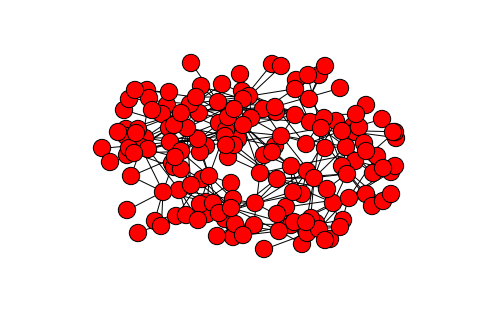

In [77]:
# Create the Subgraph 
subgraph_generator = max(networkx.connected_components(all_data_g), key =len)

subgraph_g = all_data_g.subgraph(subgraph_generator)

# color_map =[]
# for node in subgraph_g.nodes(data =True):
#     this_labels = node[1]['labels']
#     if 'Employee' in this_labels:
#         color_map.append('green')
#     elif 'Student' in this_labels:
#         color_map.append('yellow')
#     elif 'Award' in this_labels:
#         color_map.append('red')

# networkx.draw(subgraph_g, node_color=color_map)

networkx.draw(subgraph_g)

person_data = list(networkx.get_node_attributes(subgraph_g,'position').values())

print 'Number of Awards: ', networkx.number_of_nodes(subgraph_g)
print 'Number of Students: ', person_data.count('STUDENT')
print 'Number of Faculty: ', person_data.count('FACULTY')
print "Number of Awards: ",  networkx.number_of_nodes(subgraph_g) - person_data.count('STUDENT') - person_data.count('FACULTY')

In [79]:
print "_________________DEGREE CENTRALITY ________________"
calculate_degree_centrality(subgraph_g)
print "_________________Betweensess ________________"
find_cliques(subgraph_g)
print "_________________Cliques ________________"
print calculate_betweenness(subgraph_g)
print "_________________Diameter ________________"
find_diameter(subgraph_g)
print "______________________________________________"

_________________DEGREE CENTRALITY ________________
Highest degree Centrality: (a3fce5f:Employee {employeeid:"98101941",position:"FACULTY"}) 0.0696202531646
Highest degree Centrality: (b9d16ab:Employee {employeeid:"90001461",position:"FACULTY"}) 0.0569620253165
Highest degree Centrality: (ef0dae9:Employee {employeeid:"16578",position:"FACULTY"}) 0.0569620253165
Highest degree Centrality: (debdaa1:Employee {employeeid:"90028781",position:"FACULTY"}) 0.0569620253165
Highest degree Centrality: (a38c557:Employee {employeeid:"90004472",position:"FACULTY"}) 0.0569620253165
Highest degree Centrality: (b8f8672:Employee {employeeid:"90012327",position:"FACULTY"}) 0.0569620253165
Highest degree Centrality: (b64f301:Employee {employeeid:"90029332",position:"FACULTY"}) 0.0569620253165
Highest degree Centrality: (d10ceb0:Employee {employeeid:"90025970",position:"FACULTY"}) 0.0569620253165
Highest degree Centrality: (c28edcd:Employee {employeeid:"90012285",position:"FACULTY"}) 0.0569620253165
Highes

# Plotting the Results 

Betweeness and Centrality are both measures on how connnected a node is to its surounding nodes. However they meaure connectivness in slightly different ways. A Node with high Degree centrality does not nessasarily mean the node also has a high level a Betwennness Centrality.

   A node with high betweeness but low degree might indicated that a nodes few connections are critical to the shape of the graph

   A node with high degree but low betweenness might indicate that a nodes connections are redundent and connections can bypass that node
    
    
### Run the Cell below to create a scatterplot of betweeness vs centrality of our Subgraph

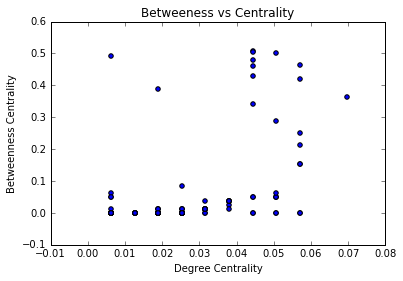

In [80]:
dc_data = list(networkx.degree_centrality(subgraph_g).values())
bw_data = list(networkx.betweenness_centrality(subgraph_g).values())

import numpy as np
import matplotlib.pyplot as plt

x = dc_data
y = bw_data

plt.scatter(x, y)

#title
plt.title("Betweeness vs Centrality")

#labels
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.show()

# Part B (X points) - Analysing Graphs

 1) Write a function that plots histgrams of the Degree of Centrality and Betweenness
     The function should take a networks graph as a parameter and return nothing
 
 2) Use the find_cliques() function to find the number of cliques in the graph 
 
 3) Based of the graph you created above, the number of cliques, and the histgrams of Centrality and Betweenness, how would you discribe the community this graph represents? 
 
 Hint: Use the networkx funtions documentation to find a function that allows you to collect the atributes of a node 

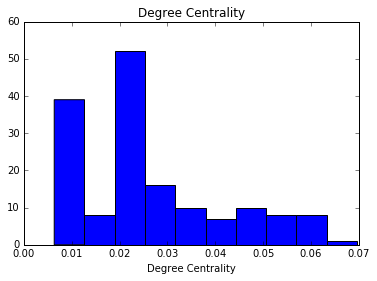

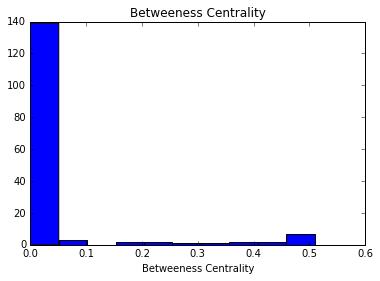

In [81]:
# Your soultion should Look somthing Like this 

def graph_data(graph):
    """
    Creates histograms of the the Degree of Centrality and the Betweenness Centrality 
    
    Parametes
    ----------
    graph - A Networkx object Graph. Graph nodes must have degress_centrality and betweenness
    
    """
    # Create an empty list to hold all of our degress_centrality items  
    cen_list = []
    # Use the built in function get_node_attributes to collect the degress_centrality for each node
    for item in networkx.get_node_attributes(graph, 'degress_centrality'):
        cen_list.append(networkx.get_node_attributes(graph, 'degress_centrality')[item])
    
    # Pass the cen_list to a plt object and plot as a histogram 
    plt.figure(1)
    #title
    plt.title("Degree Centrality")

    #labels
    plt.xlabel("Degree Centrality")
    
    plt.hist(cen_list)
    
    # Create an empty list to hold all of our eigen_cent items 
    bw_list = []
    # Use the built in function get_node_attributes to collect the eigen_cent for each node
    for item in networkx.get_node_attributes(graph, 'betweenness'):
        bw_list.append(networkx.get_node_attributes(graph, 'betweenness')[item])
    
    # Pass the eig_list to a plt object and plot as a histogram 
    plt.figure(2)
    #title
    plt.title("Betweeness Centrality")

    #labels
    plt.xlabel("Betweeness Centrality")
    plt.hist(bw_list)

    
# Call the function graph_data() on our Networkx graph 
graph_data(subgraph_g)



In [82]:
# Call the fucntion find_cliques() on our Networkx graph 
find_cliques(subgraph_g)

Number of cliques: 77
Size of cliques: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


[[(e6fc9c0:Award {award_num:"aw1012"}),
  (b8f8672:Employee {employeeid:"90012327",position:"FACULTY"}),
  (e876d9e:Employee {employeeid:"8391",position:"FACULTY"}),
  (def98e0:Employee {employeeid:"90024642",position:"FACULTY"}),
  (ef0dae9:Employee {employeeid:"16578",position:"FACULTY"})],
 [(d14148d:Award {award_num:"aw1011"}),
  (a6ca4f3:Employee {employeeid:"8791",position:"FACULTY"}),
  (b68f121:Employee {employeeid:"90001779",position:"FACULTY"}),
  (b9d16ab:Employee {employeeid:"90001461",position:"FACULTY"}),
  (ef0dae9:Employee {employeeid:"16578",position:"FACULTY"})],
 [(d77556e:Award {award_num:"aw1028"}),
  (ad6fbd2:Employee {employeeid:"90002137",position:"FACULTY"}),
  (efe0c54:Employee {employeeid:"90019945",position:"FACULTY"}),
  (c28edcd:Employee {employeeid:"90012285",position:"FACULTY"}),
  (f7d42b1:Employee {employeeid:"90029250",position:"FACULTY"})],
 [(d439e71:Award {award_num:"aw1027"}),
  (b64f301:Employee {employeeid:"90029332",position:"FACULTY"}),
  (cda